<span style="font-family:Papyrus; font-size:3em;">Computational Experiments</span>

<span style="font-family:Papyrus; font-size:2em;">One Factor at a Time (OFT)</span>

# Overview

This lecture illustrates a workflow for developing codes that run studies to do a one-factor-at-a-time (OFT) experimental design.
The running example is the model of glycolytic oscillations developed in J. Wolf et al., Biochem., 2000.

# Preliminaries

In [1]:
IS_COLAB = False

In [2]:
# Code installs. Only needed once.
if IS_COLAB:
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install scipy
    !pip install tellurium

In [3]:
# Constants for standalone notebook
if not IS_COLAB:
    DIR = "/home/ubuntu/advancing-biomedical-models/common"  # Insert your local directory path
else:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/content/drive/MyDrive/Winter 2021/common"
import sys
sys.path.insert(0, DIR)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import util_doe1

In [5]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value

# Wolf Model

We begin with an exploration of the Wolf model to understand its parameters and to determine what responses should be reported by an experiment.

## Constants for Model

In [6]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

In [7]:
# Constants used in the analysis of the Wolf model
WOLF_RR = te.loada(WOLF_MODEL)
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_DATA = WOLF_RR.simulate(START, END, NUMPT)
WOLF_PRMS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

## Exploration of the Model

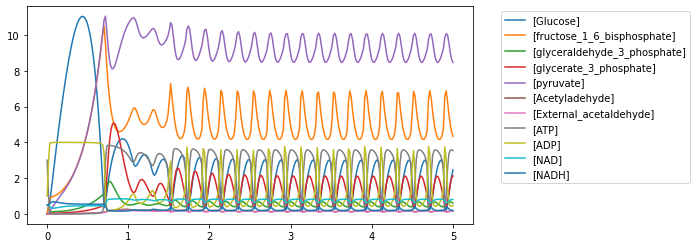

In [8]:
def timePlots(data=WOLF_DATA, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    p = ax.plot(data[:,0], data[:,1:])
    _ = ax.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
timePlots()

## Planning the Study

**Questions**
1. What are the research questions?
1. What are the factors and levels?
1. What are the responses?

# Running Simulations With Changes in Parameter Values

In [9]:
def runSimulations(parameter, percents, isPlot=True):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
          
    Returns
    -------
    dict: key=pct, value=data
    """
    roadrunner = te.loada(WOLF_MODEL)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        data = roadrunner.simulate(START, END, NUMPT)
        title = "%s: %f (%d%%)" % (parameter, newValue, percent)
        resultDct[percent] = data
        if isPlot:
            timePlots(data=data, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations("J1_Ki", percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)

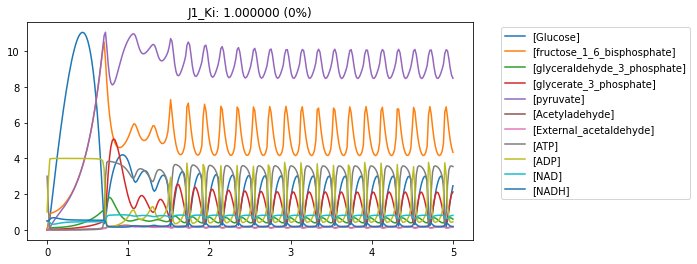

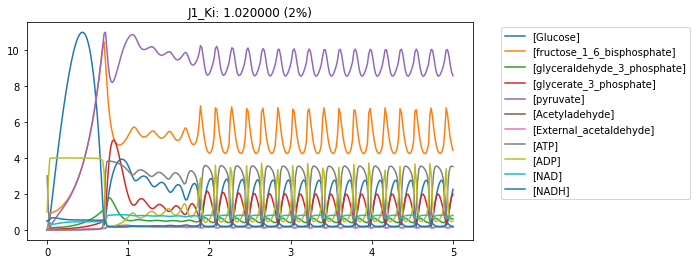

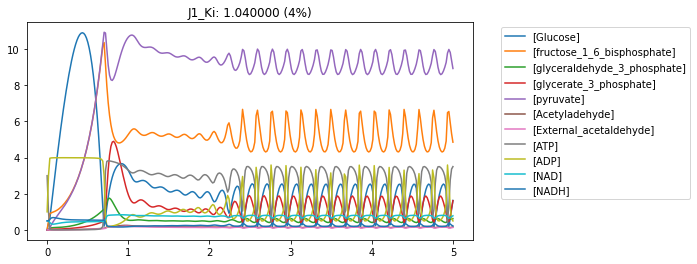

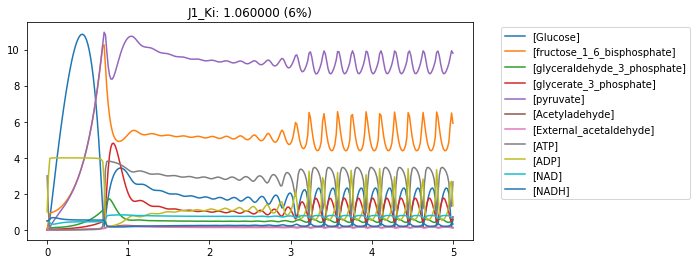

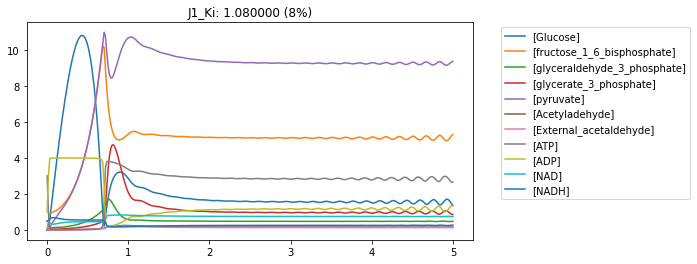

In [10]:
# Experiments 
changes = 2*np.array(range(5))
length = len(changes)
#changes = changes - float((length - 1)/2)
_ = runSimulations("J1_Ki", changes)

**Questions**
1. What happens when J1_Ki is reduced?
1. Do other parameters behave in a similar way in that the onset of cyclic behavior is delayed with a larger change?
1. What metric(s) should we use to quantify the effect on cyclic behavior?

# Calculating Responses

One way to quantify the response to changes in parameters is to use the Fast Fourier Transform (FFT).
This section develops codes that calculate responses.

In [11]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DATA)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

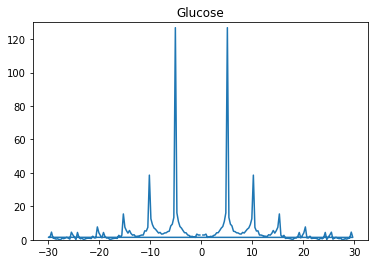

In [12]:
def plotFft(molecule, data=WOLF_DATA, ax=None, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    data: NamedArray
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    
# Tests
plotFft("Glucose")  # "Smoke" test

## Question
1. Plot FFTs for all chemical species (molecules) for the baseline values of parameters.
1. Why are there FFT peaks at multiple frequencies?
1. How do the frequencies vary across molecules?

## Solution

In [13]:
def getFrequencyAmplitude(molecule, data):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    
    Returns
    -------
    frequency: float
    amplitude: float
    """
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    frequencies, amplitudes = calculateFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(frequencies)), key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

# Tests
frequency, amplitude = getFrequencyAmplitude("Glucose", WOLF_DATA)
assert(frequency > 5.0)
assert(amplitude > 90)

# Running a Study

A study is a collection of experiments in which one or more factors is set to level different from the baseline.

## Simulations and Experiments

In [14]:
def runSimulation(parameterDct, roadrunner=None):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float
           percent change
       
    Returns
    -------
    namedArray: results of simulation
    """
    if roadrunner is None:
        roadrunner = te.loada(WOLF_MODEL)
    else:
        roadrunner.resetAll()
    for parameter, percent in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(START, END, NUMPT)
    return data

#Test
assert(len(runSimulation({"J1_Ki": 0.2})) > 0)

In [15]:
def runExperiment(parameterDct):
    """
    Runs an experiment by changing parameters by the specified fractions and calculating responses.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    amplitudeSer: pd.Series
        index: molecule
        value: largest amplitude
    """
    data = runSimulation(parameterDct)
    frequencyDct = {}
    amplitudeDct = {}
    molecules = [s[1:-1] for s in data.colnames if s != TIME]
    for molecule in molecules:
        frequency, amplitude = getFrequencyAmplitude(molecule, data)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return pd.Series(frequencyDct), pd.Series(amplitudeDct)

# Test
frequencySER, amplitudeSER = runExperiment({"J1_Ki": 0.03})
assert(len(frequencySER) == len(amplitudeSER))

### Question
1. What is the change in frequency for Glucose if J1_Ki is increased by 5% and all other parameters are unchanged?
1. What is the change if only J1_k1 is increased by 5%?
1. What is the change if *both* J1_Ki and J1_k1 are increased by 5%?
1. What is the interaction effect?

### Solution

In [16]:
# Solution
percent = 2
def getDF(parameterDct):
    frequencySer, amplitudeSer = runExperiment(parameterDct)
    baseFrequencySer, baseAmplitudeSer = runExperiment({})
    pctAmplitudeSer = 100*(amplitudeSer - baseAmplitudeSer)/baseAmplitudeSer
    return pd.DataFrame(pctAmplitudeSer).transpose()
#
baseDF = getDF({})
J1_KiDF = getDF({"J1_Ki": percent})
J1_k1DF = getDF({"J1_k1": percent})
bothDF = getDF({"J1_Ki": percent, "J1_k1": percent})
interactionDF = bothDF - (J1_KiDF + J1_k1DF)
resultDF = pd.concat([baseDF, J1_KiDF, J1_k1DF, bothDF, interactionDF])
resultDF.index = ["base", "J1_Ki", "J1_k1", "both", "interaction"]
resultDF

,Glucose,fructose_1_6_bisphosphate,glyceraldehyde_3_phosphate,glycerate_3_phosphate,pyruvate,Acetyladehyde,External_acetaldehyde,ATP,ADP,NAD,NADH
base,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
J1_Ki,-24.227591,-23.422596,-26.833063,-23.984065,-22.652624,-25.552176,-25.686884,-21.747009,-21.747009,-23.191977,-23.191977
J1_k1,-1.490985,-0.508779,-2.969398,-0.970318,0.425640,-2.878897,-2.961002,-0.267935,-0.267935,-1.394788,-1.394788
both,-15.899845,-14.683780,-20.670576,-15.803484,-12.996300,-16.390571,-16.560040,-13.977360,-13.977360,-13.638436,-13.638436
interaction,9.818731,9.247595,9.131885,9.150899,9.230684,12.040502,12.087847,8.037584,8.037584,10.948329,10.948329


## Running Multiple Experiments

In [17]:
def runExperiments(parameter, percents, isRelative=True):
    """
    Runs experiments for one parameter of the model at different percent changes in the parameter value (levels).
    
    Parameter
    ---------
    parameter: str
    percents: list-float
        percent change in parameter
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame
        index: percent
        columns: molecule
        values: percent change in frequency w.r.t. baseline
    amplitudeDF: DataFrame
        index: percent
        columns: molecule
        values: depends on isRelative
    """
    # Calculate the baseline values
    baseFrequencySer, baseAmplitudeSer = util_doe1.runExperiment({})
    #
    def calcResponseSer(ser, isFrequency=True):
        """
        Calculates the relative response.
        
        Parameters
        ----------
        ser: pd.Series
            index: molecule
            value: absolute respoinse
        isFrequency: bool
            if True, frequency response; else, amplitude response
                    
        Returns
        -------
        pd.Series
        """
        if not isRelative:
            return ser
        if isFrequency:
            baseSer = baseFrequencySer
        else:
            baseSer = baseAmplitudeSer
        resultSer = 100*(ser - baseSer)/baseSer
        return resultSer
    #
    def calcLevelResponseDF(isFrequency=None):
        """
        Calculates the dataframe of levels dataframe.
        
        Parameter
        --------
        isFrequency: bool
            If True, frequency response. Otherwise, amplitude response
            
        Returns
        -------
        pd.DataFrame
            index: tuple-int
                levels of parameters
            columns: str
                molecule
            values: response
        """
        if isFrequency is None:
            raise ValueError("Must specify isFrequency!")
        sers = []  # Collection of experiment results
        for percent in percents:
            parameterDct = {parameter: percent}
            frequencySer, amplitudeSer = runExperiment(parameterDct)
            if isFrequency:
                ser = frequencySer
            else:
                ser = amplitudeSer
            adjSer = calcResponseSer(ser, isFrequency=isFrequency)
            sers.append(pd.DataFrame(adjSer).transpose())
        resultDF = pd.concat(sers)
        resultDF.index = percents
        return resultDF
    #
    frequencyDF = calcLevelResponseDF(isFrequency=True)
    amplitudeDF = calcLevelResponseDF(isFrequency=False)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, 0, 7]
fDF, aDF = runExperiments("J1_Ki", percents)
assert(np.isclose(fDF.loc[percents[0], "Glucose"], -1*fDF.loc[percents[-1], "Glucose"]) )
assert(aDF.loc[percents[-1], "Glucose"] < 0 )
assert(aDF.loc[percents[0], "Glucose"] > 0 )

These codes make use of *internal* functions, functions that are defined inside another function. Such functions are not accessible outside the enclosing function, and they can make use of variables that are defined within the function.

### Question
1. What is the effect on the frequency of glucose if we change each parameter by 5%, leaving the other parameters at their baseline values?

### Solution

In [18]:
# Solution
molecule = "Glucose"
percent = 5
values = []
for parameter in WOLF_PRMS:
    amplitudeDF, _ = runExperiments(parameter, [percent], isRelative=False)
    value = amplitudeDF.loc[percent, molecule]
    values.append(value)
resultSer = pd.Series(values, index=WOLF_PRMS)
resultSer

J0_inputFlux    4.5
J1_k1           5.1
J1_Ki           5.7
J1_n            4.5
J2_k            5.1
J3_k            5.1
J4_kg           5.1
J4_kp           5.1
J4_ka           5.1
J4_kk           5.1
J5_k            5.1
J6_k            5.1
J7_k            5.1
J8_k1           5.1
J8_k2           5.1
J9_k            5.7
J10_k           5.1
dtype: float64

In [19]:
def runExperimentsParameters(percents=[-100, -70, -50, -10, -5, 0, 5, 10, 50, 70, 100], isRelative=True):
    """
    Collects responses for changes in all parameters
    
    Parameters
    ----------
    percents: list-float
    isRelative: bool
        True: values are relative
    
    Returns
    -------
    dict
        key: parameter
        value: frequencyDF, amplitudeDF
    """
    resultDct = {}
    for parameter in WOLF_PRMS:
        resultDct[parameter] = runExperiments(parameter, percents, isRelative=isRelative)
    return resultDct

# Tests
assert(len(runExperimentsParameters()) > 0)

**Question**
1. How does ``runExperimentsParameters`` differ from ``runExperiments``?

# Visualizing the Results of a Study

In [20]:
def runStudy(figsize=(24, 20), isPlot=True, **kwargs):
    """
    Runs a study producing plots for frequency and amplitude. Parameters of the experiment are specified in
    kwargs (see runExperimentsLevels).
    
    Parameters
    ----------
    figsize: tuple
        Size of plots produced
    isPlot: bool
        Flag to determine if generate the plot
    kwargs: dict
        See runExperimentsLevels
    """
    suptitles = ["Frequencies", "Amplitudes"]
    responseTypes = ["Absolute", "Relative"]
    ylabels = ["frequency (cycle/min)", "amplitude"]
    if "isRelative" in kwargs.keys():
        isRelative = kwargs["isRelative"]
    else:
        kwargs["isRelative"] = True
    if isRelative:
        ylims = [[-100, 100], [-100, 100]]
    else:
        ylims = [[0, 15], [0, 300]]
    resultDct = runExperimentsParameters(**kwargs)
    numRow = 5
    numCol = 4
    for responseIdx in [FREQIDX, AMPLIDX]:
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(numRow, numCol)
        ylim = ylims[responseIdx]
        responseTypeIdx = isRelative
        responseType = responseTypes[responseTypeIdx]
        for idx, parameter in enumerate(WOLF_PRMS):
            rowIdx = idx//numCol
            colIdx = idx - rowIdx*numCol
            if isPlot:
                ax = plt.subplot(gs[rowIdx, colIdx])
                _ = resultDct[parameter][responseIdx].plot(ax=ax)  # Plot the frequency dataframe
                ax.plot([0, 0], ylim, linestyle="--", color="grey")
                ax.legend("")
                ax.set_title(parameter, fontsize=FONTSIZE)
                ax.set_ylim(ylim)
                if idx == len(WOLF_PRMS) - 1:
                    ax.set_xlabel("percent change", fontsize=FONTSIZE)
                    ax.set_ylabel(ylabels[responseIdx], fontsize=FONTSIZE)
                    df = resultDct[parameter][FREQIDX]
                    _ = ax.legend(df.columns, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=FONTSIZE)
                suptitle = "%s (%s)" % (suptitles[responseIdx], responseTypes[responseTypeIdx])
                _ = plt.suptitle(suptitle, fontsize=2*FONTSIZE)
        
runStudy(isRelative=False, isPlot=False)

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

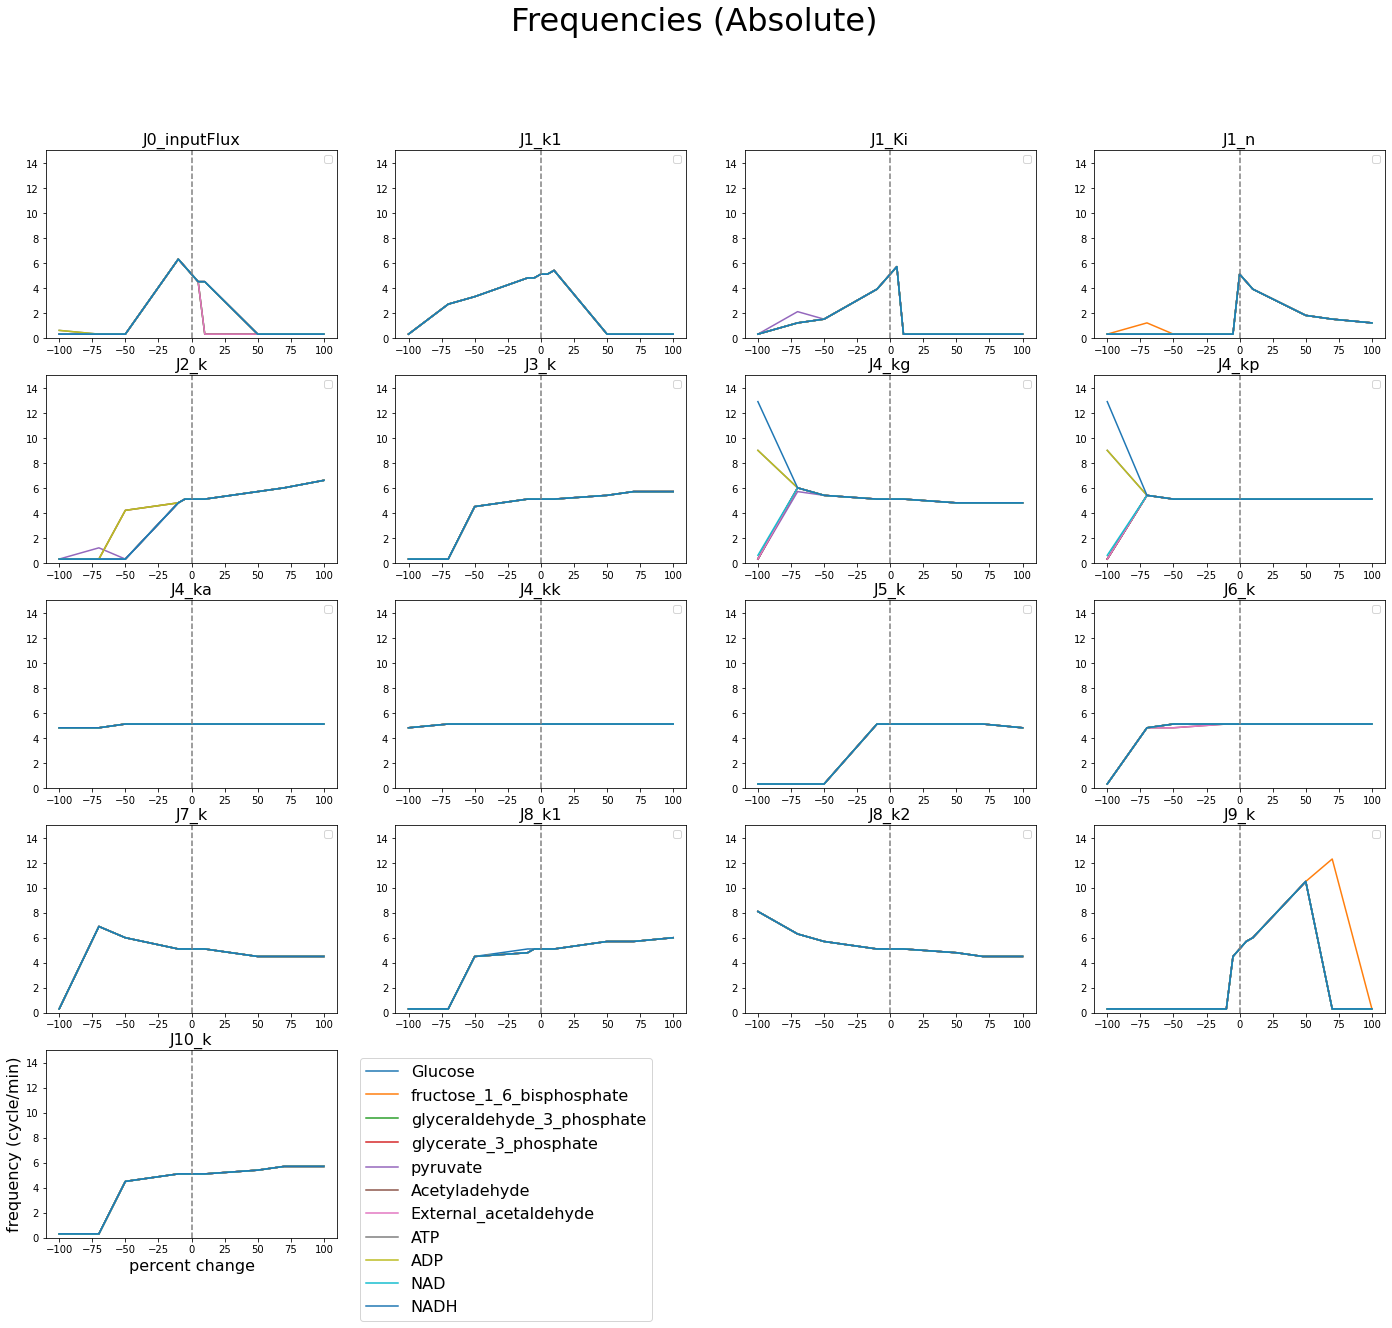

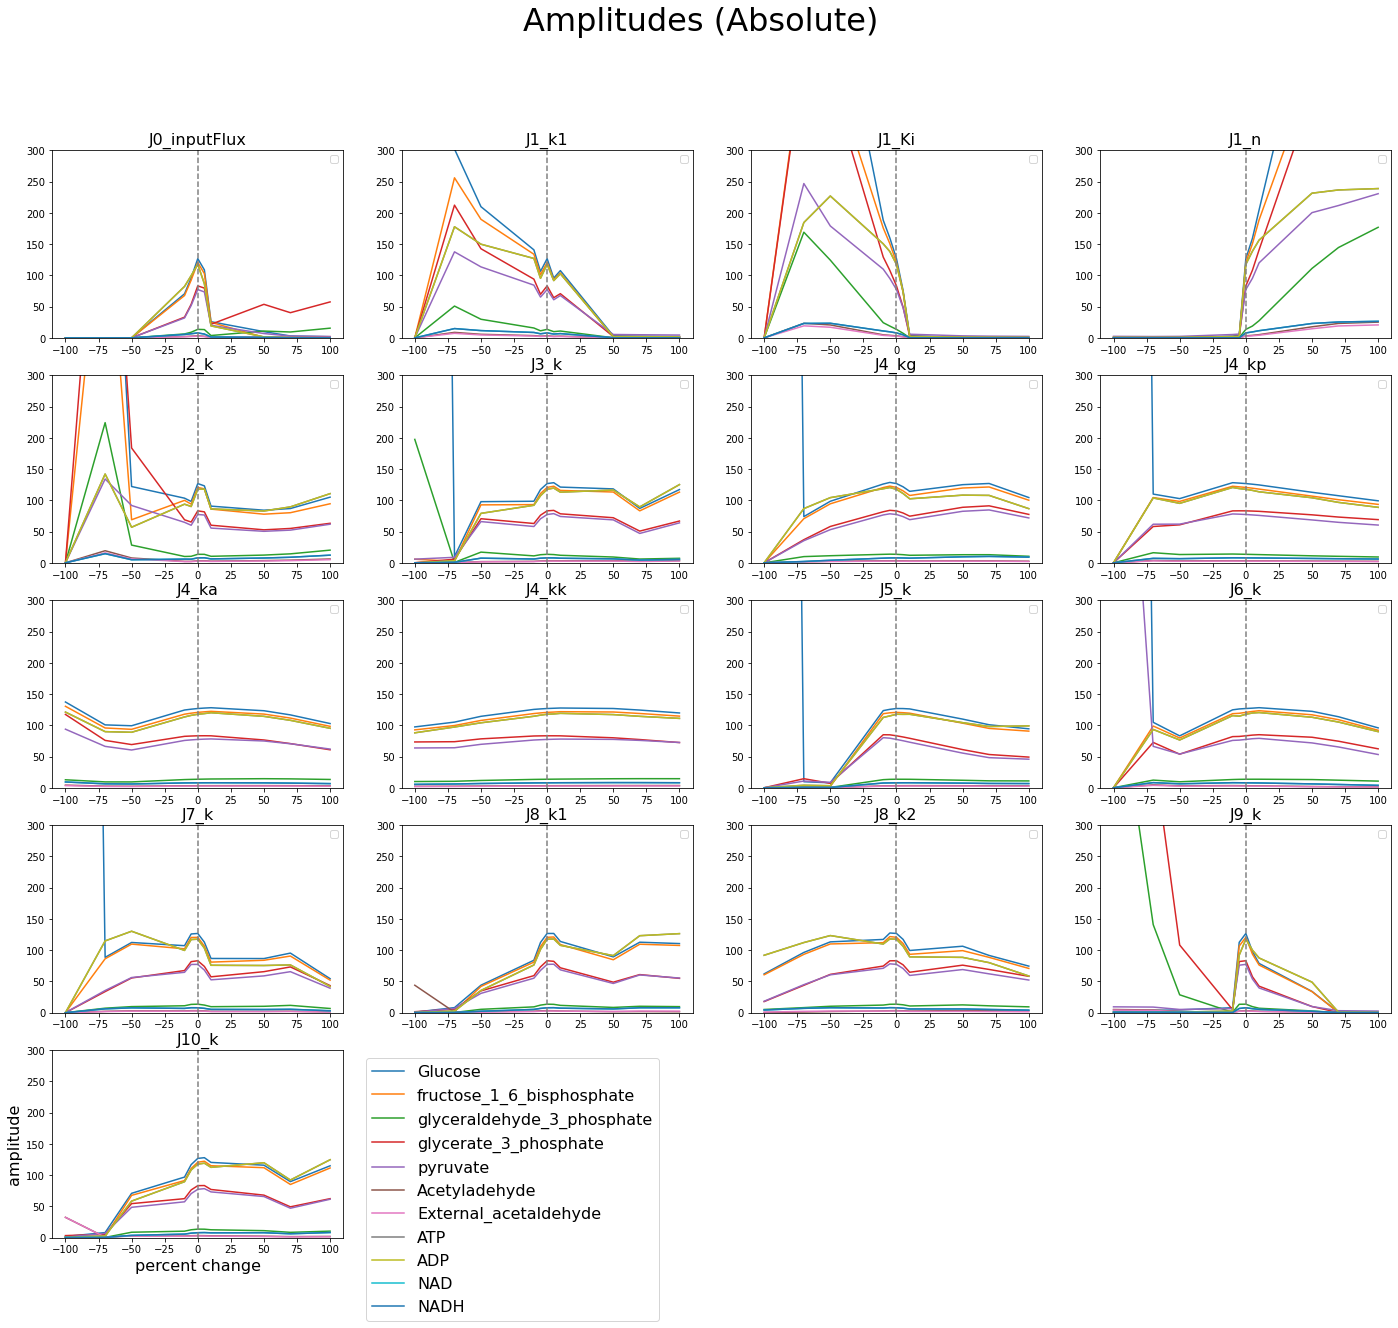

In [21]:
runStudy(isRelative=False)

**Questions**
1. Why are there only a few lines displayed in the frequency plots?
1. Which parameters have the most influence on the presence of oscillations? Which have the least?
1. Create plots that have the *relative* response. What are the advantages and disadvantages of these plots?
1. What would you change to improve these plots?

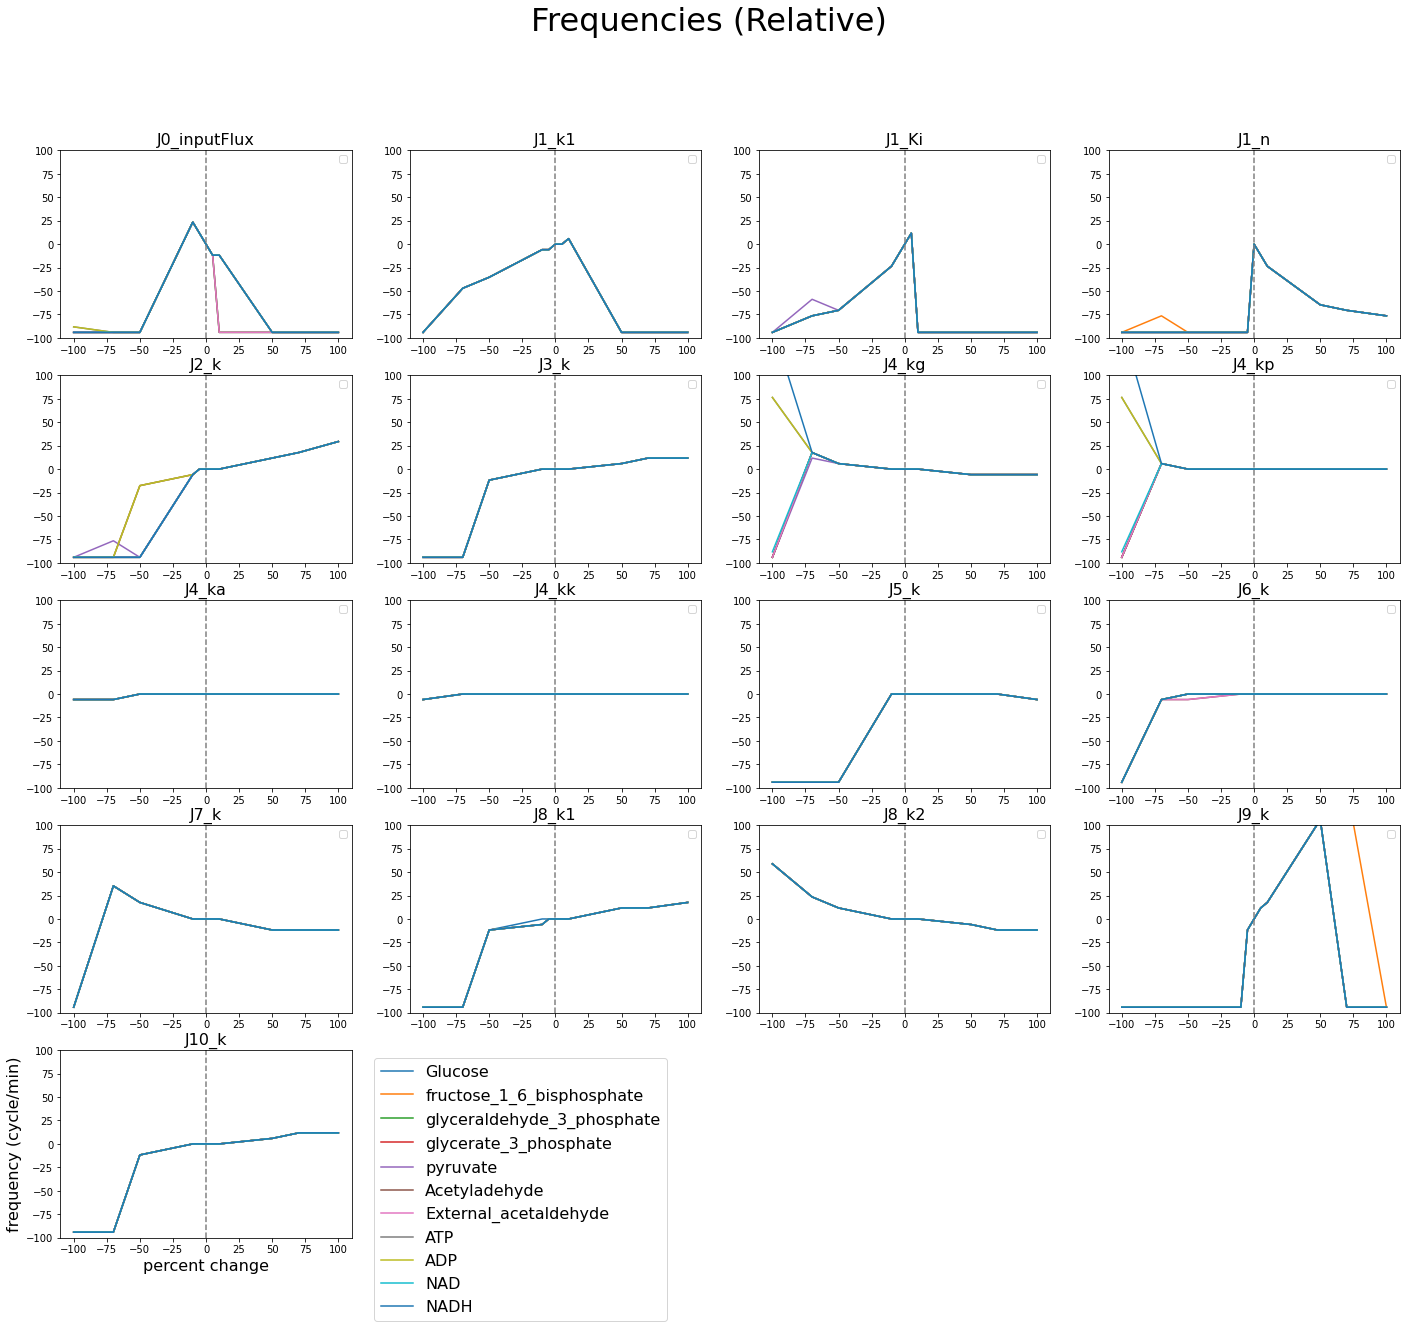

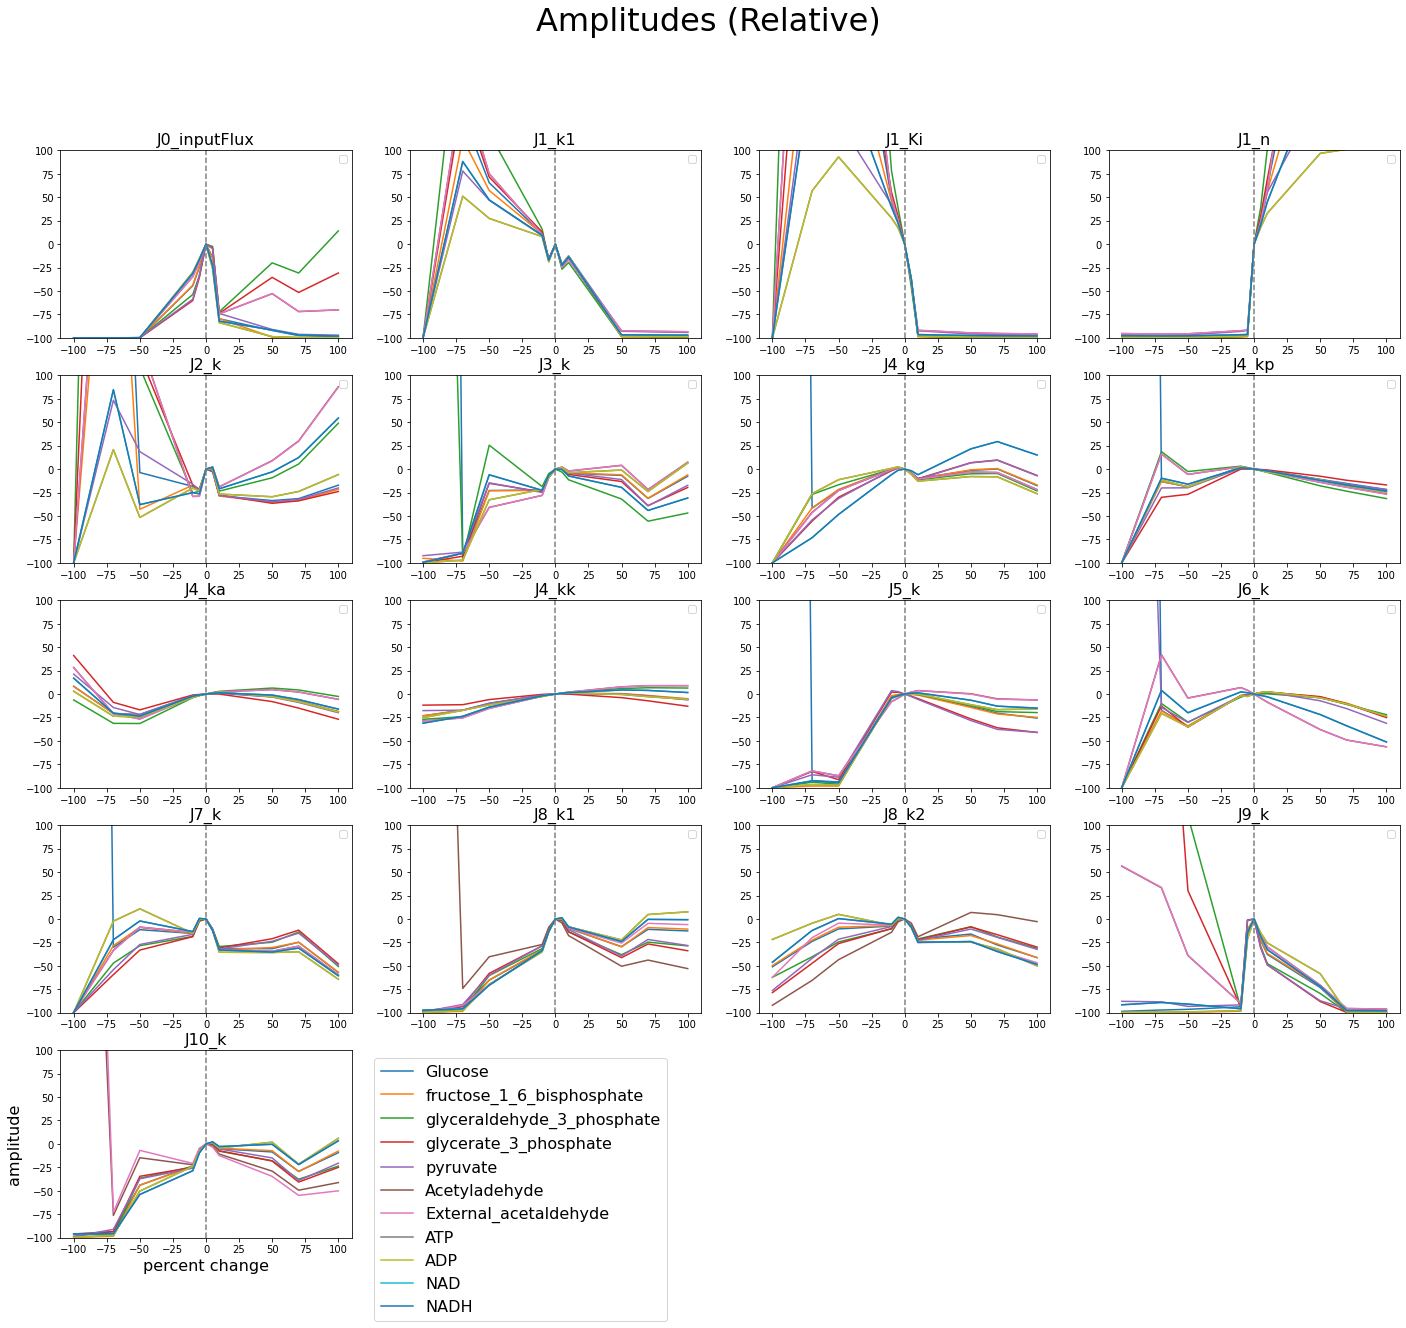

In [22]:
runStudy(isRelative=True)